# Fundamentals of Computer Vision

This Jupyter Notebook covers **Project 3** of the course and focuses on implementing Harris Corner Detector and LoG Blob Detector to introduce fundamental concepts in image processing. Each section has questions that must be answered in a Document in PDF format.

**Important**

Both the Harris Corner Detector and LoG Blob Detector tasks (Code + Answers) must be submitted; otherwise, your work will be rejected.


## Grading Breakdown: ##
- Harris Corner Detector: 50 points (Code: 30 pts, Answers: 20 pts).
- LoG Blob Detector: 50 points (Code: 30 pts, Answers: 20 pts).

To pass Project 3, a minimum of **50 points** is required.

# **Feature Extraction**

## **Harris Corner Detector**

In this exercise, you will implement the Harris corner detection algorithm to identify corner features in images. Follow these steps to complete the implementation of the `harris_corner_detection()` function:

1. Convert to Grayscale: Convert the input image to grayscale with floating-point precision.

2. Compute Image Gradients: Compute the first derivatives $I_x$ and $I_y$ using Sobel filter, which was implemented in Project 1.

3. Compute Gradient Products: Calculate $I_x^2$, $I_y^2$ and $I_x I_y$.

4. Smooth with Gaussian: Smooth the gradient products using a Gaussian filter.

5. Construct Local Structure Matrix (M): Form the local structure matrix $M$ using the smoothed gradient products:

\begin{equation}
M = \begin{bmatrix}
I_x^2 & I_x I_y \\
I_x I_y & I_y^2
\end{bmatrix}
\end{equation}

6. Calculate Eigenvalues: Compute the eigenvalues $\lambda_1$ and $\lambda_2$ of the matrix $M$.

7. Compute Harris Response: Calculate the Harris response $R = \lambda_1 \lambda_2 - k (\lambda_1 + \lambda_2)^2$.

8. Threshold and Mark Corners: Threshold the response $R$ to detect corners and highlight them in the image.

9. Return: Return the image with corners marked in red and Harris response $R$.

In [310]:
# Import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [311]:
# Sobel filter function
def sobel_filter(image, kernel_x, kernel_y, stride=1):
    
    kernel_size,_ = np.shape(kernel_x)
    
    # try to force same padding
    padding = (kernel_size - 1) // 2
    
    # Determine if the image is grayscale or color
    if len(image.shape) == 2:  # Grayscale image
        # Apply padding
        image_padded = np.pad(image, ((padding, padding), (padding, padding)), mode='constant')
        height_image, width_image = image.shape
        
        # Create output matrices for gradients
        gradient_x = np.zeros(((height_image + 2 * padding - kernel_x.shape[0]) // stride + 1, 
                               (width_image + 2 * padding - kernel_x.shape[1]) // stride + 1))
        gradient_y = np.zeros_like(gradient_x)
        
        # Convolve the image with Sobel kernels
        for y in range(gradient_x.shape[0]):
            for x in range(gradient_x.shape[1]):
                region = image_padded[y * stride:y * stride + kernel_x.shape[0], x * stride:x * stride + kernel_x.shape[1]]
                gradient_x[y, x] = np.sum(region * kernel_x)
                gradient_y[y, x] = np.sum(region * kernel_y)
        
        # Compute gradient magnitude
        gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
        
        gradient_x = gradient_x.astype(np.float64)
        gradient_y = gradient_y.astype(np.float64)
        
        
        return gradient_x, gradient_y, gradient_magnitude
    
    else:  # Color image
        channels_x = []
        channels_y = []
        for c in range(image.shape[2]):  # Loop through each channel (R, G, B)
            # Apply padding
            image_padded = np.pad(image[:, :, c], ((padding, padding), (padding, padding)), mode='constant')
            height_image, width_image = image[:, :, c].shape
            
            # Create output matrices for gradients
            gradient_x = np.zeros(((height_image + 2 * padding - kernel_x.shape[0]) // stride + 1, 
                                   (width_image + 2 * padding - kernel_x.shape[1]) // stride + 1))
            gradient_y = np.zeros_like(gradient_x)
            
            # Convolve the image with Sobel kernels for each channel
            for y in range(gradient_x.shape[0]):
                for x in range(gradient_x.shape[1]):
                    region = image_padded[y * stride:y * stride + kernel_x.shape[0], x * stride:x * stride + kernel_x.shape[1]]
                    gradient_x[y, x] = np.sum(region * kernel_x)
                    gradient_y[y, x] = np.sum(region * kernel_y)
            
            # Store gradients for each channel
            channels_x.append(gradient_x)
            channels_y.append(gradient_y)
        
        # Stack the gradients from each channel
        gradient_x = np.stack(channels_x, axis=2)
        gradient_y = np.stack(channels_y, axis=2)
        
        # Compute the gradient magnitude
        gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
        
        gradient_x = gradient_x.astype(np.float64)
        gradient_y = gradient_y.astype(np.float64)
        
        
        return gradient_x, gradient_y, gradient_magnitude

In [312]:
def gaussian_kernel(kernel_size, sigma):
    """
    Creates a Gaussian kernel.

    Parameters:
        kernel_size (int): Size of the kernel (must be odd).
        sigma (float): Standard deviation for the Gaussian distribution.

    Returns:
        np.ndarray: Gaussian kernel.
    """
    if kernel_size % 2 == 0:
        raise ValueError("Kernel size must be an odd number.")

    # Create a grid of (x,y) coordinates
    ax = np.linspace(-(kernel_size // 2), kernel_size // 2, kernel_size)
    xx, yy = np.meshgrid(ax, ax)

    # Calculate the Gaussian function
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))

    # Normalize the kernel
    kernel /= np.sum(kernel)

    return kernel

def gaussian_filter(image, kernel_size=5, sigma=1.0, stride = 1):
    """
    Applies a Gaussian Filter to the given image.

    Parameters:
        image (np.ndarray): Input image (2D array for grayscale, 3D for RGB).
        kernel_size (int): Size of the Gaussian kernel (must be odd).
        sigma (float): Standard deviation for the Gaussian distribution.

    Returns:
        np.ndarray: Filtered image.
        
    """
    
    # try to force same padding
    padding = (kernel_size - 1) // 2
    

    # Create the Gaussian kernel
    kernel = gaussian_kernel(kernel_size, sigma)

    # Use your convolution function
    
    # 3. Use your convolution function
    if len(image.shape) == 2:  # Grayscale image
         image_padded = np.pad(image, ((padding, padding), (padding, padding)), mode='constant')
         height_image, width_image = image.shape
         output = np.zeros(((height_image + 2 * padding - kernel.shape[0]) // stride + 1, (width_image + 2 * padding - kernel.shape[1]) // stride + 1))
         for y in range(output.shape[0]):
             for x in range(output.shape[1]):
                 region = image_padded[y * stride:y * stride + kernel.shape[0], x * stride:x * stride + kernel.shape[1]]
                 output[y, x] = np.sum(region * kernel)
         return output
 
    else:  # Color image
         channels = []
         for c in range(image.shape[2]):
             image_padded = np.pad(image[:, :, c], ((padding, padding), (padding, padding)), mode='constant')
             height_image, width_image = image[:, :, c].shape
             output = np.zeros(((height_image + 2 * padding - kernel.shape[0]) // stride + 1,
                                (width_image + 2 * padding - kernel.shape[1]) // stride + 1))
             for y in range(output.shape[0]):
                 for x in range(output.shape[1]):
                     region = image_padded[y * stride:y * stride + kernel.shape[0], x * stride:x * stride + kernel.shape[1]]
                     output[y, x] = np.sum(region * kernel)
             channels.append(output)
         return np.stack(channels, axis=2)


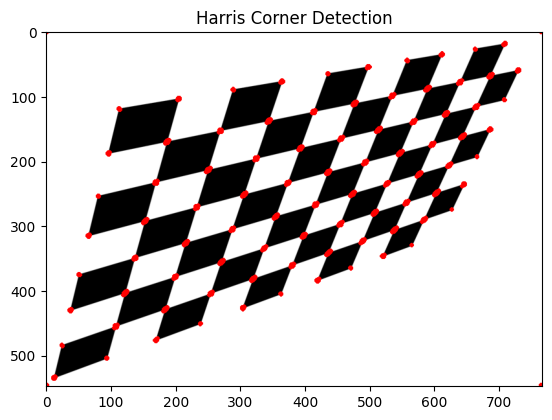

In [313]:

def harris_corner_detector(image, k=0.04, window_size=3, threshold=1e-2):

    # Convert to Grayscale: Convert the input image to grayscale with floating-point precision.

    if len(image.shape) == 3:
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        image_gray = image
    image_gray = image_gray.astype(np.float32)
   

    
    #Compute Image Gradients: Compute the first derivatives $I_x$ and $I_y$ using Sobel filter, which was implemented in Project 1.
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]) 
    
    I_x, I_y, I_magnitude = sobel_filter(image_gray, sobel_x, sobel_y)
    
    # Compute Gradient Products: Calculate $I_x^2$, $I_y^2$ and $I_x I_y$.
    I_x_squared = I_x * I_x
    I_y_squared = I_y * I_y
    I_x_y = I_x * I_y 
    
    #Smooth with Gaussian: Smooth the gradient products using a Gaussian filter.
    gaussianfiltered_I_x_squared = gaussian_filter(I_x_squared, kernel_size=window_size, sigma=1.0, stride = 1)
    gaussianfiltered_I_y_squared = gaussian_filter(I_y_squared, kernel_size=window_size, sigma=1.0, stride = 1)
    gaussianfiltered_I_x_y = gaussian_filter(I_x_y, kernel_size=window_size, sigma=1.0, stride = 1)
    
    #Form the local structure matrix $M$ using the smoothed gradient products: Not necesary here because I directly calculated the eigenvalues

    # Calculate Eigenvalues: Compute the eigenvalues $\lambda_1$ and $\lambda_2$ of the matrix $M$
    lambda_1 = (gaussianfiltered_I_x_squared + gaussianfiltered_I_y_squared + np.sqrt(gaussianfiltered_I_x_squared**2-2*gaussianfiltered_I_x_squared*gaussianfiltered_I_y_squared+gaussianfiltered_I_y_squared**2+4*gaussianfiltered_I_x_y**2))
    lambda_2 = (gaussianfiltered_I_x_squared + gaussianfiltered_I_y_squared - np.sqrt(gaussianfiltered_I_x_squared**2-2*gaussianfiltered_I_x_squared*gaussianfiltered_I_y_squared+gaussianfiltered_I_y_squared**2+4*gaussianfiltered_I_x_y**2))
    
    #Compute Harris Response
    R = lambda_1*lambda_2-k*(lambda_1+lambda_2)**2
    
    # Threshold and Mark Corners
    corner_image = image.copy()
    corners = R > threshold * R.max()
    
    
    if len(image.shape) == 3:
        corner_image[corners] = [0, 0, 255]  # Red
    else:  # If grayscale, convert to BGR and then mark corners
        #corner_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        corner_image[corners] = [0, 0, 255]
        
    # highlight coners with red circles
    coordinates = np.argwhere(corners)
        
    for y, x in coordinates:  
        cv2.circle(corner_image, (x, y), radius=2, color=(0, 0, 255), thickness=2)
    
    

    return corner_image, R


# Load the image
image = cv2.imread('images/chessboard_perspective.png')
#image = cv2.imread(path_images + 'lenna.png')

# Detect corners
harris_image, response = harris_corner_detector(image, k=0.05, window_size=3, threshold=1e-2)

# Display the result
plt.imshow(cv2.cvtColor(harris_image, cv2.COLOR_BGR2RGB))
plt.title('Harris Corner Detection')
plt.savefig("corners.pdf", dpi = 200)
plt.show()

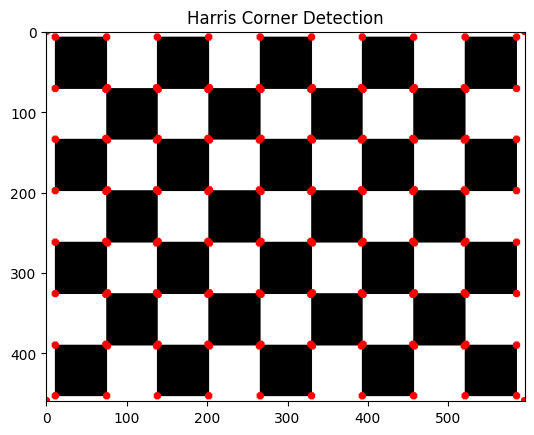

In [315]:
# Load the image
image = cv2.imread('images/chessboard.jpg')
#image = cv2.imread(path_images + 'lenna.png')

# Detect corners
harris_image, response = harris_corner_detector(image, k=0.05, window_size=3, threshold=1e-2)

# Display the result
plt.imshow(cv2.cvtColor(harris_image, cv2.COLOR_BGR2RGB))
plt.title('Harris Corner Detection')
plt.savefig("corners.pdf", dpi = 200)
plt.show()

**Questions that must be included in your Report**.

Answer the questions briefly and directly, including the images obtained from the execution of your code to explain your conclusions. Answers must be connected to the executed code.


1. Why is Gaussian smoothing applied to the gradient products $I_x^2$, $I_y^2$ and $I_x I_y$, and what effect does it have on the results?

2. What would happen if the matrix $M$ were structured as:

\begin{equation}
M = \begin{bmatrix}
I_x^2 & 0 \\
0 & I_y^2
\end{bmatrix}
\end{equation}

3. How does the Harris response $R$ reflect the strength of a corner, and what would happen if the threshold value was set too high or too low?

4. What is the significance of the constant $k$ in the Harris response formula, and how would changing its value influence the detection of corners?

5. The Harris Corner Detector:

  A. Is it robust in detecting corners, even in the presence of noise?

  B. Is it not invariant to scale or rotation?

  C. Is it sensitive to changes in illumination?

  D. Does it fail to inherently handle affine transformations, limiting its applicability for tracking features across different perspectives?


# **LoG Blob Detector**

In this exercise, you will implement the Laplacian of Gaussian (LoG)algorithm to identify blobs in images. Follow these steps to complete the implementation of the `detect_blobs_log()` function:

1. Generate LoG Filters: Create scale-normalized Laplacian of Gaussian filters at several scales (different scales means different sigma).

2. Convolve Image: Apply the LoG filters to the image and build a scale-space representation.

3. Find Peaks: Find maxima of squared Laplacian response in scale-space and apply a threshold to filter weak responses.

4. Draw Blobs: Visualise detected blobs with circles corresponding to their scale.

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

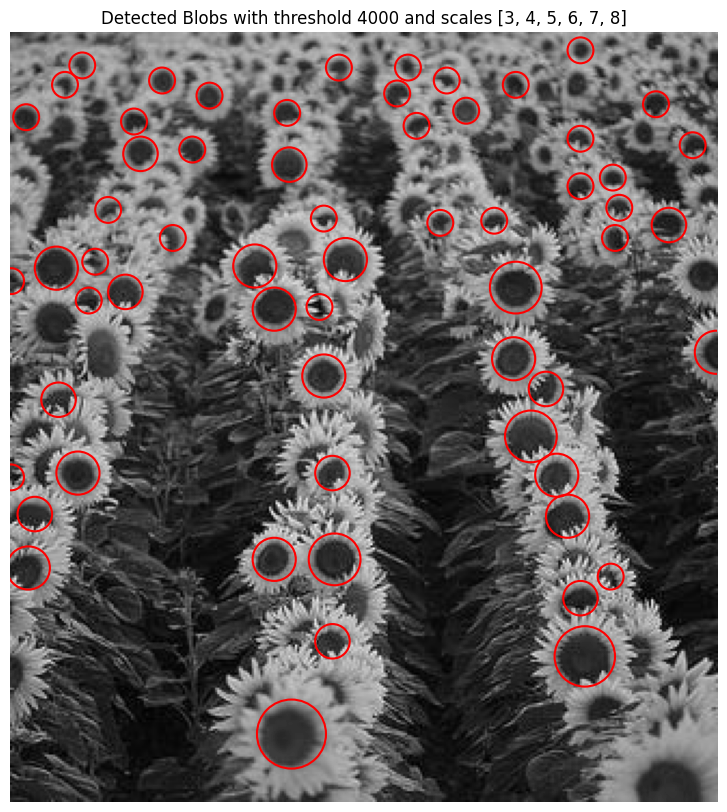

In [308]:
def detect_blobs_log(image, scales, threshold=0.1):
    # Check if color and convert to gray
    if len(image.shape) == 3:
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        image_gray = image
        
    scale_space = []
    
    for sigma in scales:
        size = int(2 * np.ceil(3 * sigma)+1) # make the size of the gauß kernel sigma dependent
        
        GaussianKernel1D = cv2.getGaussianKernel(size, sigma) # create a 1D Gaussian
        GaussianKernel2D = GaussianKernel1D @ GaussianKernel1D.T # create a 2D Gaussian

        nG = GaussianKernel2D / np.sum(GaussianKernel2D) # normalize gaussian
       
        LoG = cv2.Laplacian(nG , cv2.CV_64F) # calculate Laplacian of normalized gaussian
        
        nLoG = LoG * ((sigma**2)) # sigma normalized LoG
    
        filtered_image = cv2.filter2D(image_gray.astype(float), -1, nLoG) # convolute the nLoG filter with the image
        
        scale_space.append(filtered_image**2) # append to scale-space
    
    scale_space = np.stack(scale_space, axis=-1)
    

    # Find local maxima in the 3D scale space
    local_max = maximum_filter(scale_space, size=(3, 3, 3))  # max filter in 3D
    maxima = (scale_space == local_max) & (scale_space > threshold)  # threshold the local max values 
    
    blob_indices = np.argwhere(maxima)  # indices of maxima in 3D
    coordinates = [(int(x), int(y), scales[int(s)]) for y, x, s in blob_indices]

    # add the circles to the image 
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image_gray, cmap='gray')
    for x, y, sigma in coordinates:
        circle = plt.Circle((x, y), radius=2 * sigma, color='red', linewidth=1.5, fill=False)
        ax.add_patch(circle)
    plt.axis('off')
    plt.title(f"Detected Blobs with threshold {threshold} and scales {scales}")
    plt.savefig(f"Detected_Blobs_with_threshold_{threshold}_and_scales_{scales}.pdf")
    plt.show()
    
    

# Load the image
image = cv2.imread('images/sunflowers.jpg') #, cv2.IMREAD_GRAYSCALE)

# Define the scales (sigma values)
scales = [3, 4, 5, 6, 7, 8]  # You can adjust these for more resolution at different scales [1.5, 1.7, 2, 6]

threshold = 4000 #1.8

# Detect blobs using LoG
detect_blobs_log(image, scales, threshold)

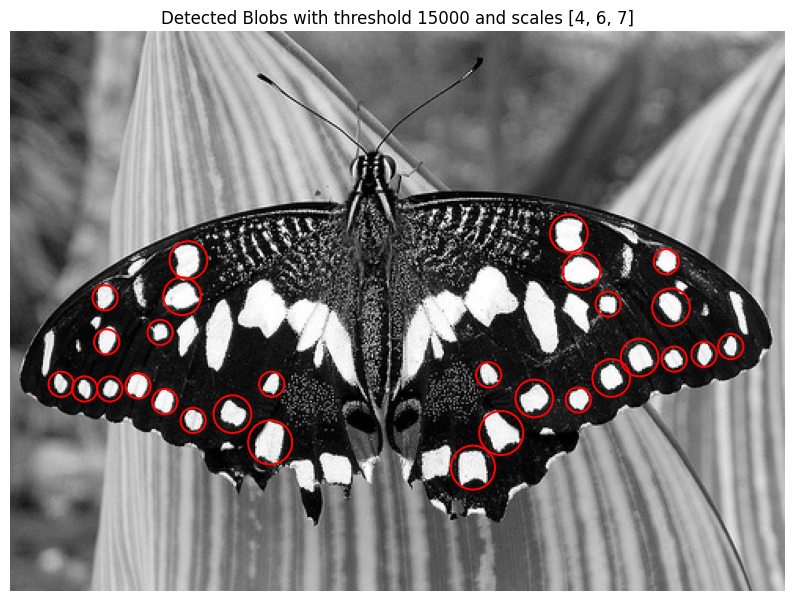

In [309]:
    # Load the image
image = cv2.imread('images/butterfly.jpg') #, cv2.IMREAD_GRAYSCALE)

# Define the scales (sigma values)
scales = [4, 6, 7]  # You can adjust these for more resolution at different scales [1.5, 1.7, 2, 6]

threshold = 15000 #1.8

# Detect blobs using LoG
detect_blobs_log(image, scales, threshold)

In [298]:
def salt_pepper(image, salt_prob, pepper_prob):
    """
    Add salt and pepper noise to an image.

    :param image: Input image (NumPy array).
    :param salt_prob: Probability of adding salt noise (white pixels).
    :param pepper_prob: Probability of adding pepper noise (black pixels).
    :return: Noisy image with salt and pepper noise added.
    """
    noisy_image = np.copy(image)

    # Salt noise (white pixels)
    num_salt = np.ceil(salt_prob * image.size).astype(int)
    coords_salt = [np.random.randint(0, i - 1, num_salt) for i in image.shape]
    noisy_image[tuple(coords_salt)] = 255  # For salt (white)

    # Pepper noise (black pixels)
    num_pepper = np.ceil(pepper_prob * image.size).astype(int)
    coords_pepper = [np.random.randint(0, i - 1, num_pepper) for i in image.shape]
    noisy_image[tuple(coords_pepper)] = 0  # For pepper (black)

    return noisy_image

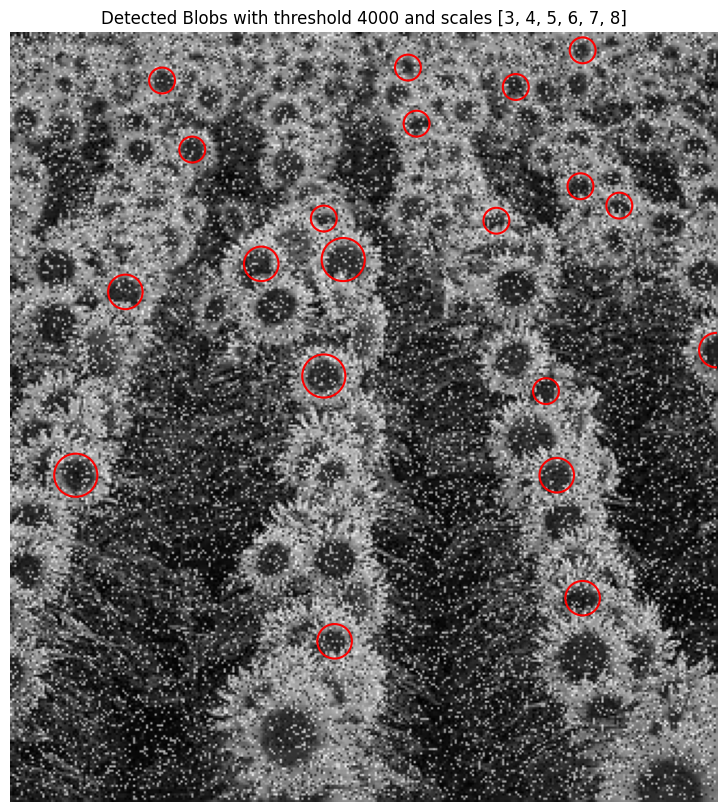

In [299]:
# Load the image
image = cv2.imread('images/sunflowers.jpg') #, cv2.IMREAD_GRAYSCALE)

salt_prob = 0.1
pepper_prob = 0.1
noisy_image = salt_pepper(image, salt_prob, pepper_prob)



# Define the scales (sigma values)
scales = [3, 4, 5, 6, 7, 8]  # You can adjust these for more resolution at different scales [1.5, 1.7, 2, 6]

threshold = 4000 #1.8

# Detect blobs using LoG
detect_blobs_log(noisy_image, scales, threshold)

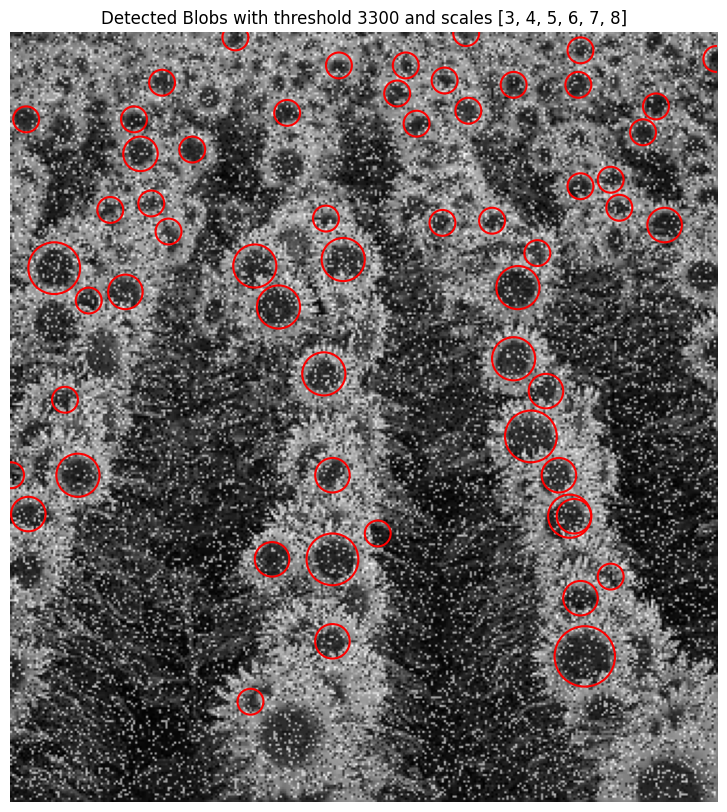

In [307]:
# Load the image
image = cv2.imread('images/sunflowers.jpg') #, cv2.IMREAD_GRAYSCALE)

salt_prob = 0.1
pepper_prob = 0.1
noisy_image = salt_pepper(image, salt_prob, pepper_prob)



# Define the scales (sigma values)
scales = [3, 4, 5, 6, 7, 8]  # You can adjust these for more resolution at different scales [1.5, 1.7, 2, 6]

threshold = 3300 #1.8

# Detect blobs using LoG
detect_blobs_log(noisy_image, scales, threshold)

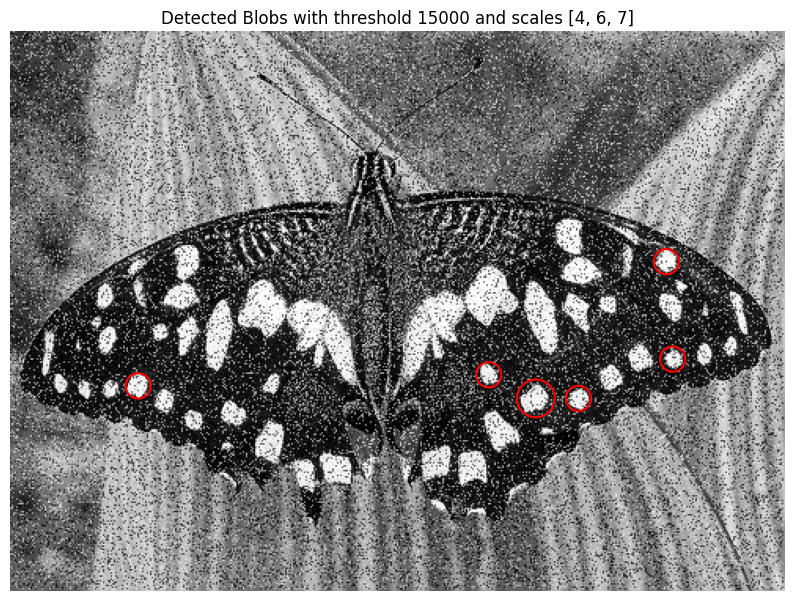

In [301]:
# Load the image
image = cv2.imread('images/butterfly.jpg') #, cv2.IMREAD_GRAYSCALE)

salt_prob = 0.1
pepper_prob = 0.1
noisy_image = salt_pepper(image, salt_prob, pepper_prob)



# Define the scales (sigma values)
scales = [4, 6, 7]  # You can adjust these for more resolution at different scales [1.5, 1.7, 2, 6]

threshold = 15000 #1.8

# Detect blobs using LoG
detect_blobs_log(noisy_image, scales, threshold)

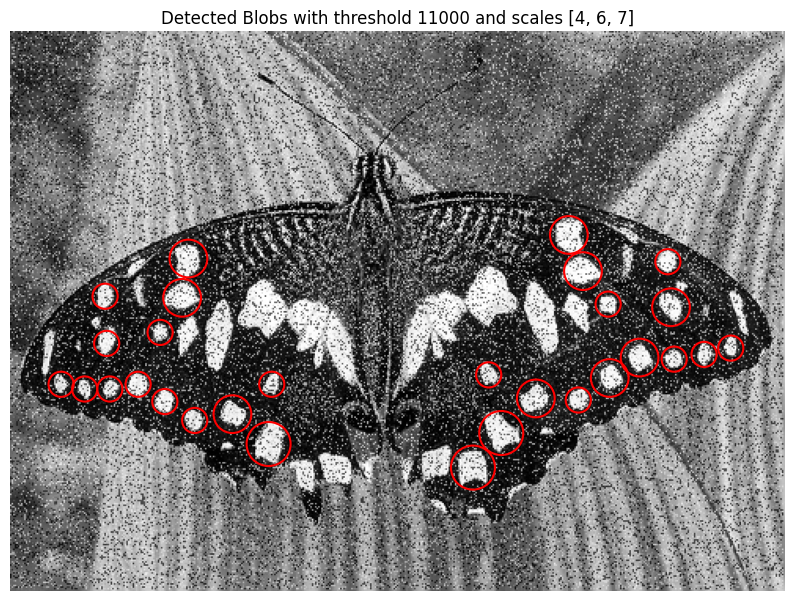

In [303]:
# Load the image
image = cv2.imread('images/butterfly.jpg') #, cv2.IMREAD_GRAYSCALE)

salt_prob = 0.1
pepper_prob = 0.1
noisy_image = salt_pepper(image, salt_prob, pepper_prob)



# Define the scales (sigma values)
scales = [4, 6, 7]  # You can adjust these for more resolution at different scales [1.5, 1.7, 2, 6]

threshold = 11000 #1.8

# Detect blobs using LoG
detect_blobs_log(noisy_image, scales, threshold)

**Questions that must be included in your Report**.

Answer the questions briefly and directly, including the images obtained from the execution of your code to explain your conclusions. Answers must be connected to the executed code.

6. What is the purpose of the Laplacian of Gaussian (LoG) filter in the context of blob detection?

7. How does the sigma value affect the LoG filter, and why is it important to use multiple scales when detecting blobs?

8. LoG Blob Detector:

  A. Is the LoG blob detector robust to noise?

  B. Is the LoG blob detector scale-invariant but not rotation-invariant?

  C. How does the LoG blob detector handle changes in illumination?

  D. Does the LoG blob detector fail to inherently handle affine transformations, limiting its applicability for tracking features across different perspectives?

